# ruBERT text classification

## Шаг 0 - Описание

Полезные ссылки:

https://newtechaudit.ru/klassifikacziya-teksta-s-ispolzovaniem-modelej-transformerov/

https://huggingface.co/datasets/zloelias/kinopoisk-reviews

https://huggingface.co/ai-forever/ruBert-base

## Шаг 1 - Подготовка окружения

In [39]:
# Устанавливаем зависимости

%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [40]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tqdm.pandas()

# Для mac выбираем mps
device = torch.device('mps')

## Шаг 2 - Подготовка данных

In [41]:
from datasets import load_dataset

dataset = load_dataset("zloelias/kinopoisk-reviews")

In [43]:
dataset['train'][10]

{'text': "Главного героя сериала 'Шанс' - психиатра Элдона Ченса (Хью Лорри) - мы застаем в не самый лучший период его жизни - идет развод, раздел имущества, привычный мир разрушен и будущее неопределенно. Все покрыто каким-то туманом. Появится ли в этом тумане луч света, или взор совсем померкнет во мгле?\n\nОтвет на этот вопрос дает сам Элдон Ченс. Он психиатр, поэтому, казалось бы, он должен понимать работу человеческой психики, видеть ее лекала, предчувствовать опасности и лихие повороты судьбы. Тем не менее, события развиваются по евангельской присказке 'Врач, исцели себя самого', произнесенной с известной мерой сарказма. \n\nБольшую часть жизни Элдон прятался от себя в лечении пациентов. Он думал, что знает, чем они страдают, какие экзистенциальные вопросы их мучают, привык действовать по раз и навсегда прописанным правилам. Но стоит жизни заставить Элдона оказаться один на один с самим собой, вне спасавшей его от проблемы экзистенции ракушки - и он пасует. \n\nПомощь ему берется

In [44]:
train_text = dataset['train']['text']
test_text = dataset['test']['text']

<Axes: >

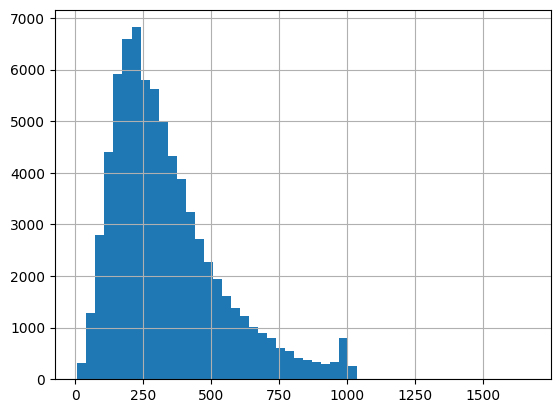

In [45]:
seq_len = [len(str(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins = 50)

In [48]:
tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = 350,
    padding = 'max_length',
    truncation = True
)

## Шаг 3 - Подготовка модели

In [60]:
from transformers import pipeline
from base import baseModel, tokenizer

unmasker = pipeline('fill-mask', model=baseModel, tokenizer=tokenizer)

[i['sequence'] for i in unmasker("[MASK] - самый классный город в мире")]

Some weights of the model checkpoint at ai-forever/ruBert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['Москва - самый классный город в мире',
 'Казань - самый классный город в мире',
 'Питер - самый классный город в мире',
 'Стамбул - самый классный город в мире',
 'Хельсинки - самый классный город в мире']

In [49]:
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = 350,
    padding = 'max_length',
    truncation = True
)

In [50]:
train_labels = dataset['train']['labels']
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

In [51]:
test_labels = dataset['test']['labels']
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

In [52]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = 8)

In [72]:
len(train_dataloader)

9228

In [54]:
from transformers import AdamW
from model import BERT_Arch

model = BERT_Arch().to(device)

optimizer = AdamW(model.parameters(), lr = 1e-3)

/Users/turist/projects/sber/digital-teams/.venv/lib/python3.9/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Шаг 4 - Обучение модели

In [61]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_weights)

weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss(weights)

[0.78413461 1.37986467]


In [62]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

In [64]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []
epochs = 20
for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss = train()

    train_losses.append(train_loss)

    print(f'\nTraining loss: {train_loss:.3f}')



 Epoch1 / 20


  0%|          | 0/9228 [00:00<?, ?it/s]

  0%|          | 0/9228 [00:01<?, ?it/s]


ValueError: not enough values to unpack (expected 2, got 1)